# Softmax Regression - MNIST

The purpose of this notebook is to implement a softmax regression algorithm in order to classify hand-written digits from the MNIST database. First, I implement a simple version of the algorithm by hand, then compare the performance against the sklearn python library.

Softmax regression is a generalization of logistic regression that allows one to group response variables into multiple classes.


## Import libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import input_data

from scipy.optimize import fmin_l_bfgs_b
from sklearn.preprocessing import OneHotEncoder

import scikitplot as skplt

## Import and plot MNIST data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


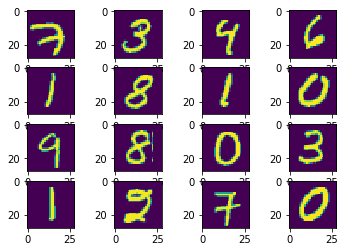

In [14]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
train = mnist.train.next_batch(5000)
test = mnist.train.next_batch(1000)

fig = plt.figure()
for i in range(1,17):
    fig.add_subplot(4, 4, i)
    image_data = train[0][i-1,:]
    image = np.reshape(image_data,[28,28])
    plt.imshow(image)

## Manual Implementation of Softmax Regression

In [15]:
'''Initialize the design matrix and dimension variables'''
x = train[0]
y = train[1]
m = np.size(x, 0)
n = np.size(x, 1)
num_labels = len(np.unique(y))

'''Initialize labels and parameter vector with bias. Reorient parameter matrix'''
thetas = np.zeros((n, num_labels)) 
#X = np.append(np.ones((m, 1)), X, 1)


In [16]:
def oneHot(y):
    '''Converts MNIST label classes into a one-hot representation'''
    # Create onehot encoder object
    onehot_encoder = OneHotEncoder(sparse=False)
    
    # Generate onehot encoded labels
    y_reshape = np.reshape(y,(len(y), 1))
    y_onehot = onehot_encoder.fit_transform(y_reshape)
    
    return y_onehot

In [17]:
def softmax(x, thetas):   
    # Compute the softmax
    nu = x.dot(thetas) 
    prob = ((np.exp(nu)).T / np.sum(np.exp(nu), axis=1)).T
    
    return prob

In [18]:
def predict(x, thetas):
    nu = x.dot(thetas)
    probs = softmax(x, thetas)
    predictions = np.argmax(probs, axis=1)
    
    return probs, predictions

def modelAccuracy(x, y, thetas):
    probs, predictions = predict(x, thetas)
    accuracy = sum(y == predictions)/len(y)
    return probs, accuracy

In [24]:
def costFunction(thetas, x, y, m, lamb):
    '''Cost function for the softmax regression algorithm'''
    # Compute onehot representation of y
    y_hot = oneHot(y)
    
    # Compute the softmax
    prob = softmax(x, thetas)
    
    # Compute the cost function
    cost = (-1 / m) * np.sum(y_hot*np.log(prob)) + (lamb/2)*np.sum(thetas*thetas)
    
    # Compute the gradient
    grad = (-1 / m) * ((x.T).dot(y_hot - prob)) + lamb*thetas
    
    return cost, grad

'''Gradient descent training'''
n_iter = 1000
num_labels = 10
alpha = 0.01
lamb = 1

cost_history = []             
for i in range(0, n_iter):
    cost, grad = costFunction(thetas, x, y, m, lamb)
    cost_history.append(cost)
    thetas = thetas - (alpha * grad)


ValueError: too many values to unpack (expected 2)

### Evaluation Metrics

Training accuracy 0.7862
Test accuracy 0.784


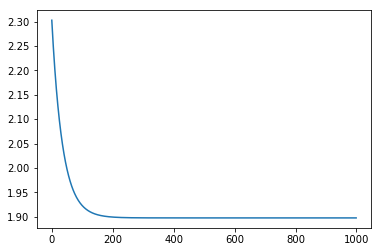

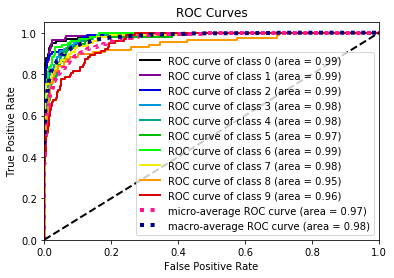

In [20]:
'''Compare training accuracy and test accuracy'''

x_test = test[0]
y_test = test[1]

probs_train, train_accuracy = modelAccuracy(x, y, thetas)
probs_test, test_accuracy = modelAccuracy(x_test, y_test, thetas)
print('Training accuracy', train_accuracy)
print('Test accuracy', test_accuracy)

plt.plot(cost_history)
skplt.metrics.plot_roc(y_test, probs_test)

## Scikit learn implementation of Softmax Regression

In [35]:
'''Initialize the design matrix and dimension variables'''
x = train[0]
y = train[1]
m = np.size(x, 0)
n = np.size(x, 1)
num_labels = len(np.unique(y))

lamb = 1

'''Initialize labels and parameter vector with bias. Reorient parameter matrix'''
thetas = np.zeros((n, num_labels)) 
#X = np.append(np.ones((m, 1)), X, 1)

'''BFGS algorithm training '''

def costFunctionBFGS(thetas, x, y, m, lamb):
    '''Cost function for the softmax regression algorithm'''
    # BFGS algorithm only takes flattened version of parameter matrix, so need to reshape
    thetas = thetas.reshape(x.shape[1], num_labels)
    
    # Compute onehot representation of y
    y_hot = oneHot(y)
    
    # Compute the softmax
    nu = x.dot(thetas) 
    prob = ((np.exp(nu)).T / np.sum(np.exp(nu), axis=1)).T
    
    # Compute the cost function
    cost = (-1 / m) * np.sum(y_hot*np.log(prob)) + (lamb/2)*np.sum(thetas*thetas)

    # Compute the gradient
    grad = (-1 / m) * ((x.T).dot(y_hot - prob)) + lamb*thetas
    
    return cost, grad.ravel()

# Execute BFGS algorithm
thetas_opt, j, ret  = fmin_l_bfgs_b(costFunctionBFGS, thetas, args=(x, y, m, lamb),epsilon=1e-08, disp=1)
thetas_opt = thetas_opt.reshape(x.shape[1], num_labels)


### Evaluation Metrics

Training accuracy 0.7864
Test accuracy 0.784


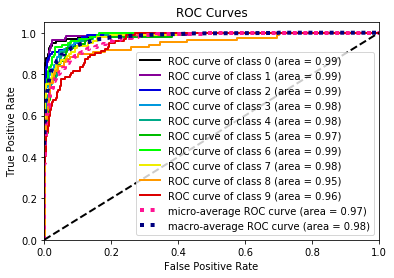

In [36]:
'''Compare training accuracy and test accuracy'''

x_test = test[0]
y_test = test[1]

probs_train, train_accuracy = modelAccuracy(x, y, thetas_opt)
probs_test, test_accuracy = modelAccuracy(x_test, y_test, thetas_opt)
print('Training accuracy', train_accuracy)
print('Test accuracy', test_accuracy)

skplt.metrics.plot_roc(y_test, probs_test)